# RNN 구현

In [129]:
import cupyx
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
        
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out
    
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
            
        return None

## RNN 계층 구현

In [130]:
import numpy as np

class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None  # 역전파에 사용할 중간 데이터

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)  # tanh 미분
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)  # shape: (H, N) x (N, H) = (H, H)
        dh_prev = np.dot(dt, Wh.T)  # shape: (N, H) x (H, H) = (N, H)
        dWx = np.dot(x.T, dt)  # shape: (D, N) x (N, H) = (D, H)
        dx = np.dot(dt, Wx.T)  # shape: (N, H) x (H, D) = (N, D)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

# 시계열 데이터 처리 계층 구현

In [131]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        
        self.h, self.dh = None, None
        self.stateful = stateful
        
    def set_state(self, h):
        self.h = h
        
    def reset_state(self):
        self.h = None
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
            
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape
        
        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx
            
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
            
        self.dh = dh
        return dxs

In [132]:
# common/time_layers.py
class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W
        
    def forward(self, xs):
        N, T = xs.shape  # N(batch), T(timesteps)
        V, D = self.W.shape  # V(vocab_size), D(embedding_size)
        
        out = np.empty((N, T, D), dtype='f')
        self.layers = []
        
        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)
        
        return out
    
    def backward(self, dout):
        N, T, D = dout.shape
        
        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]
            
        self.grads[0][...] = grad
        return None

In [133]:
class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None
        
    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params
        
        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)
    
    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params
        
        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)
        
        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)
        
        self.grads[0][...] = dW
        self.grads[1][...] = db
        
        return dx

In [134]:
class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1
        
    def forward(self, xs, ts):
        N, T, V = xs.shape
        
        if ts.ndim == 3:  # 정답 레이블이 원핫 벡터인 경우
            ts = ts.argmax(axis=2)
        
        mask = (ts != self.ignore_label)
        
        # 배치용과 시계열용을 정리(reshape)
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)
        
        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_label에 해당하는 데이터는 손실을 0으로 설정
        loss = -np.sum(ls)
        loss /= mask.sum()
        
        self.cache = (ts, ys, mask, (N, T, V))
        return loss
    
    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache
        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_label에 해당하는 데이터는 기울기 0으로 설정
        
        dx = dx.reshape((N, T, V))
        
        return dx

# RNNLM 학습과 평가

## RNNLM 구현

In [135]:
import numpy as np

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rm = np.random.randn
        
        embed_W = (rm(V, D)/100).astype('f')
        rnn_Wx = (rm(D, H)/np.sqrt(D)).astype('f')
        rnn_Wh = (rm(H, H)/np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rm(H, V)/np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()

## RNNLM의 학습 코드

In [136]:
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from common.functions import softmax, cross_entropy_error

In [137]:
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5
lr = 0.1
max_epoch = 100

In [138]:
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

In [139]:
xs = corpus[:-1]
ts = corpus[1:]
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

말뭉치 크기: 1000, 어휘 수: 418


In [140]:
max_iters = data_size // (batch_size*time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

In [141]:
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

In [142]:
jump = (corpus_size - 1) // batch_size
offsets = [i*jump for i in range(batch_size)]
offsets

[0, 99, 198, 297, 396, 495, 594, 693, 792, 891]

In [143]:
for epoch in range(max_epoch):
    for iter in range(max_iters):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset+time_idx) % data_size]
                batch_t[i, t] = ts[(offset+time_idx) % data_size]
            time_idx += 1
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

| 에폭 1 | 퍼플렉서티 403.60
| 에폭 2 | 퍼플렉서티 295.55
| 에폭 3 | 퍼플렉서티 231.26
| 에폭 4 | 퍼플렉서티 219.68
| 에폭 5 | 퍼플렉서티 208.26
| 에폭 6 | 퍼플렉서티 204.61
| 에폭 7 | 퍼플렉서티 199.28
| 에폭 8 | 퍼플렉서티 196.71
| 에폭 9 | 퍼플렉서티 191.65
| 에폭 10 | 퍼플렉서티 192.34
| 에폭 11 | 퍼플렉서티 188.59
| 에폭 12 | 퍼플렉서티 192.21
| 에폭 13 | 퍼플렉서티 189.82
| 에폭 14 | 퍼플렉서티 189.81
| 에폭 15 | 퍼플렉서티 188.94
| 에폭 16 | 퍼플렉서티 184.97
| 에폭 17 | 퍼플렉서티 182.91
| 에폭 18 | 퍼플렉서티 179.45
| 에폭 19 | 퍼플렉서티 180.18
| 에폭 20 | 퍼플렉서티 183.05
| 에폭 21 | 퍼플렉서티 179.72
| 에폭 22 | 퍼플렉서티 175.53
| 에폭 23 | 퍼플렉서티 172.64
| 에폭 24 | 퍼플렉서티 174.55
| 에폭 25 | 퍼플렉서티 172.42
| 에폭 26 | 퍼플렉서티 171.83
| 에폭 27 | 퍼플렉서티 166.76
| 에폭 28 | 퍼플렉서티 162.97
| 에폭 29 | 퍼플렉서티 161.53
| 에폭 30 | 퍼플렉서티 153.89
| 에폭 31 | 퍼플렉서티 158.55
| 에폭 32 | 퍼플렉서티 153.41
| 에폭 33 | 퍼플렉서티 151.09
| 에폭 34 | 퍼플렉서티 145.59
| 에폭 35 | 퍼플렉서티 142.86
| 에폭 36 | 퍼플렉서티 139.17
| 에폭 37 | 퍼플렉서티 132.58
| 에폭 38 | 퍼플렉서티 129.13
| 에폭 39 | 퍼플렉서티 126.11
| 에폭 40 | 퍼플렉서티 118.61
| 에폭 41 | 퍼플렉서티 120.11
| 에폭 42 | 퍼플렉서티 112.25
| 에폭 43 | 퍼플렉서티 107.09
| 에폭 44 | 퍼플렉서티 101.

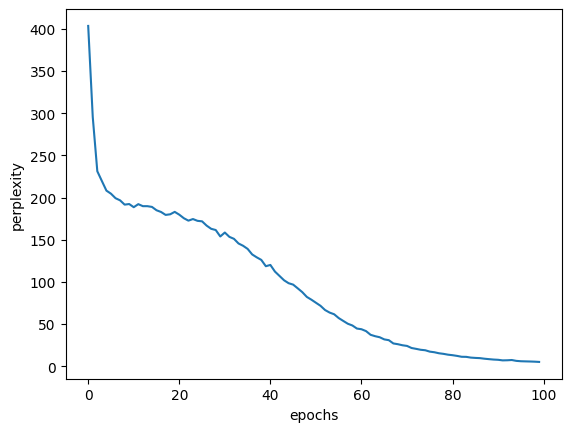

In [144]:
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

| 에폭 1 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 416.32
| 에폭 2 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 415.08
| 에폭 3 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 360.68
| 에폭 4 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 249.05
| 에폭 5 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 218.69
| 에폭 6 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 213.83
| 에폭 7 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 204.04
| 에폭 8 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 202.01
| 에폭 9 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 196.39
| 에폭 10 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 191.91
| 에폭 11 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 192.61
| 에폭 12 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 188.79
| 에폭 13 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 191.73
| 에폭 14 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 187.53
| 에폭 15 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 186.70
| 에폭 16 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 192.62
| 에폭 17 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 188.75
| 에폭 18 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 184.63
| 에폭 19 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 180.30
| 에폭 20 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 181.69
| 에폭 21 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 179.74
| 에폭 22 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 179.

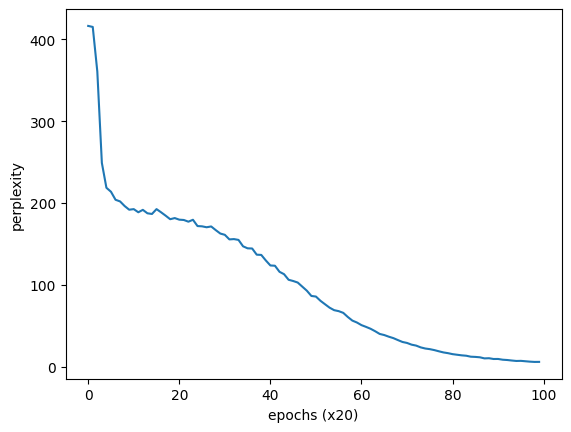

In [145]:
# chap05/train.py
%matplotlib inline
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from dataset import ptb

# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 5  # RNN을 펼치는 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000  # 테스트 데이터셋을 작게 설정
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
xs = corpus[:-1]  # 입력
ts = corpus[1:]  # 출력（정답 레이블）

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()